**Install libraries**

In [17]:
#!brew install libomp
#!pip3 install pandas
#!pip3 install scikit-learn
#!pip3 install xgboost

**Import libraries**

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import Lasso
from scipy import stats
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
%matplotlib inline

# **Data Importation and Pre-processing**

**Import Data**

In [ ]:
# For google drive
#from google.colab import drive
#from google.colab import files

#drive.mount('/content/drive')
#data_dir = "/content/drive/My Drive/FYP/midland/"

In [ ]:
# For local directory
data_dir = "./midland/"

In [ ]:
hk_island = [
  "Chai_wan", "Heng_fa_chuen", "Shau_kei_wan", "Sai_wan_ho_tai_koo", "Quarry_bay", "North_point_fortress_hill", 
  "Braemar_hill_north_point_mid_level", "Jardines_lookout_tai_hang", "Happy_valley_mid_level_east", "Wan_chai_causeway_bay", 
  "Tin_hau", "Central_mid_level_admiralty", "Sheung_wan_central", "Hong_kong_west", "Western_mid_levels", "The_peak", 
  "Residence_bel_air_pokfulam", "Ap_lei_chau", "Aberdeen_wong_chuk_hang", "Repulse_bay_shou_son_hill", "Tai_tam_shek_o", "Stanley"
]

kowloon = [
  "Tsim_sha_tsui", "Kowloon_station", "Yau_ma_tei", "Kingspark", "Mongkok", "Tai_kok_tsui", "Olympic", "Lai_chi_kok", "Mei_foo", 
  "Cheung_sha_wan_sham_shui_po", "Yau_yat_tsuen", "Kowloon_tong_beacon_hill", "Ho_man_tin", "Hung_hum", "To_kwa_wan", "Kai_tak", 
  "Kowloon_city", "Wong_tai_sin_lok_fu", "Diamond_hill_san_po_kong_ngau_chi_wan", "Kowloon_bay", "Kwun_tong", "Lam_tin_yau_tong", 
  "Lohas_park", "Tiu_keng_leng", "Hang_hau", "Po_lam_tseung_kwan_o_station"
]

new_territory = [
  "Sai_kung_clear_water_bay", "Shatin", "Kau_to_shan_fotan", "Ma_on_shan", "Tai_po", "North", "Sheung_shui_fanling", "Hung_shui_kiu", 
  "Fairview_palm_springs_the_vineyard", "Tin_shui_wai", "Yuen_long", "Tuen_mun", "Tsuen_wan", "Sham_tseng", "Ma_wan", "Kwai_chung", 
  "Tsing_yi", "Discovery_bay", "Tung_chung", "Lan_tau_island"
]


In [ ]:
# Data directory
dir_hk_island = "./hk_island/"
dir_kowloon = "./kowloon/"
dir_new_territory = "./new_territory/"

def get_data_by_region(region_name, disctrict_dir):

  region_df = pd.DataFrame()
  for region in region_name:
    new_df = pd.read_csv(data_dir+disctrict_dir+region+".csv")
    region_df = pd.concat([region_df, new_df], axis=0)

  # Data cleaning
  region_df = region_df.drop(region_df.columns[0], axis=1)

  region_df['tx_date'] = pd.to_datetime(region_df['tx_date'], dayfirst=True)
  region_df['first_op_date'] = pd.to_datetime(region_df['first_op_date'], dayfirst=True)
  region_df['last_tx_date'] = pd.to_datetime(region_df['last_tx_date'], dayfirst=True)

  region_df['floor'] = region_df['floor'].replace("-", np.nan)
  region_df['flat'] = region_df['flat'].replace("-", np.nan)

  region_df['area'] = region_df['area'].replace(0, np.nan)
  region_df['net_area'] = region_df['net_area'].replace(0, np.nan)
  region_df['last_price'] = region_df['last_price'].replace(0, np.nan)
  region_df['floor'] = region_df['floor'].astype('str') 
  region_df = region_df[~region_df['floor'].str.contains("&") == True]
  region_df['floor'] = region_df['floor'].replace("G", 0).replace("LG", 0).replace("LG1", 0)
  region_df['floor'] = region_df['floor'].apply(pd.to_numeric, errors = 'coerce')

  region_df.sort_values(by=['tx_date'], inplace=True, ascending=False)

  region_df = region_df.reset_index()
  region_df = region_df.drop(['index'], axis=1)
  return region_df

def download_data(filename, download_data):
  dataFrame = pd.DataFrame(data=download_data)
  dataFrame.to_csv(filename)
  files.download(filename)

# Get data by region
data_df_hk_island = get_data_by_region(hk_island, dir_hk_island)
data_df_kowloon = get_data_by_region(kowloon, dir_kowloon)
data_df_new_territory = get_data_by_region(new_territory, dir_new_territory)

# Get all region data
data_df_all = pd.concat([data_df_hk_island, data_df_kowloon, data_df_new_territory], axis=0)
data_df_all.sort_values(by=['tx_date'], inplace=True, ascending=False)
data_df_all = data_df_all.reset_index()
data_df_all = data_df_all.drop(['index'], axis=1)

data_df_all.columns = ['region', 'subregion', 'district', 'estate', 'building', 'firstOpDate',
                      'floorL', 'bedroom', 'sittingroom', 'floor', 'flat', 'grossArea', 'saleableArea',
                      'price', 'regDate', 'lastRegDate', 'lastPrice', 'gain', 'lat', 'lon']

**Feature Engineering**

In [ ]:
def removeOutlier(df, col):
  # Calculate mean and standard deviation
  data_mean, data_std = np.mean(df[col]), np.std(df[col])

  # Calculate upper boundary
  upper = data_mean + data_std * 3
  
  # Remove outliers
  df = df[df[col] < upper]

  return df

In [ ]:
processed_df = data_df_all.copy()

# Make new features
processed_df['buildingAge'] = pd.to_datetime("today").year - pd.DatetimeIndex(processed_df['firstOpDate']).year
processed_df['month'] = pd.to_datetime(processed_df['regDate']).dt.month
processed_df['year'] = pd.to_datetime(processed_df['regDate']).dt.year
processed_df['monthYear'] = pd.to_datetime(processed_df['regDate']).dt.to_period('M')

# Drop unneccessary columns and columns with too many missing values
processed_df = processed_df.drop(['firstOpDate', 'lastRegDate', 'sittingroom'], axis=1) 

# Fill missing values with 0
processed_df['floorL'] = processed_df['floorL'].fillna('Unknown')
processed_df['lat'] = processed_df['lat'].fillna(0)
processed_df['lon'] = processed_df['lon'].fillna(0)

# Fill missing values wiith mean values
bedroom_mean = processed_df['bedroom'].mean()
processed_df['bedroom'] = processed_df['bedroom'].fillna(bedroom_mean)
processed_df['bedroom'] = processed_df['bedroom'].astype(int)

saleableArea_mean = processed_df['grossArea'].mean()
processed_df['grossArea'] = processed_df['grossArea'].fillna(saleableArea_mean)

saleableArea_mean = processed_df['saleableArea'].mean()
processed_df['saleableArea'] = processed_df['saleableArea'].fillna(saleableArea_mean)

saleableArea_mean = processed_df['lastPrice'].mean()
processed_df['lastPrice'] = processed_df['lastPrice'].fillna(saleableArea_mean)

buildingAge_mean = processed_df['buildingAge'].mean()
processed_df['buildingAge'] = processed_df['buildingAge'].fillna(buildingAge_mean)
processed_df['buildingAge'] = processed_df['buildingAge'].astype(int)

floor_mean = processed_df['floor'].mean()
processed_df['floor'] = processed_df['floor'].fillna(floor_mean)
processed_df['floor'] = processed_df['floor'].astype(int)

# Label encoding for categorical features
cols = ('region', 'subregion', 'district', 'estate', 'building', 
        'floorL', 'flat', 'monthYear')
for col in cols:
    le = LabelEncoder() 
    le.fit(list(processed_df[col].values)) 
    processed_df[col] = le.transform(list(processed_df[col].values))

processed_df = removeOutlier(processed_df, 'price')
#processed_df = removeOutlier(processed_df, 'grossArea')
#processed_df = removeOutlier(processed_df, 'saleableArea')

**Feature Selection**

In [ ]:
data_df = processed_df.copy()
data_df = data_df.drop(['flat', 'building', 'lat', 'lon', 'month', 'estate', 'monthYear', 'gain', 'year', 'floorL', 'district', 'subregion', 'regDate'], axis=1) 

# **Predictive Models (Preliminary results)**

In [ ]:
# Random seed
RAND_SEED = 1234
# Size of training dataset
TRAIN_SIZE = 0.8

**Evaluation Metrics**

In [27]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y), np.expm1(y_pred)))

def rmsle(y, y_pred):
  return np.sqrt(mean_squared_log_error(y, y_pred))

**Train/Test split**

In [28]:
all_idx = list(range(len(data_df)))

random.seed(RAND_SEED)
random.shuffle(all_idx)

# Split the random indices into two portion
p = int(len(data_df) * TRAIN_SIZE)
train_idx = all_idx[:p]
test_idx = all_idx[p:]

# Retrieve training and test data
train_df = data_df.iloc[train_idx]
test_df = data_df.iloc[test_idx]

# Reset index
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# Drop index column
train_df = train_df.drop(['index'], axis=1)
test_df = test_df.drop(['index'], axis=1)

print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131864 entries, 0 to 131863
Data columns (total 8 columns):
region          131864 non-null int64
bedroom         131864 non-null int64
floor           131864 non-null int64
grossArea       131864 non-null float64
saleableArea    131864 non-null float64
price           131864 non-null float64
lastPrice       131864 non-null float64
buildingAge     131864 non-null int64
dtypes: float64(4), int64(4)
memory usage: 8.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32966 entries, 0 to 32965
Data columns (total 8 columns):
region          32966 non-null int64
bedroom         32966 non-null int64
floor           32966 non-null int64
grossArea       32966 non-null float64
saleableArea    32966 non-null float64
price           32966 non-null float64
lastPrice       32966 non-null float64
buildingAge     32966 non-null int64
dtypes: float64(4), int64(4)
memory usage: 2.0 MB
None


In [29]:
feat_col = [ c for c in train_df.columns if c not in ['price'] ]
x_train, y_train = train_df[feat_col], train_df['price']
x_test, y_test  = test_df[feat_col], test_df['price']

**Log Transformation**

In [30]:
log_y_train= np.log1p(y_train)

**XGB**

In [78]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', 
                       learning_rate = 0.1, max_depth = 5, alpha = 10, 
                       random_state=RAND_SEED, n_estimators = 2000)

model_xgb.fit(x_train, log_y_train)
xgb_train_pred = np.expm1(model_xgb.predict(x_train))
xgb_test_pred = np.expm1(model_xgb.predict(x_test))
print("RMSLE(train): ", rmsle(y_train, xgb_train_pred))
print("RMSLE(test): ", rmsle(y_test, xgb_test_pred))

RMSLE(train):  0.16079357443118433
RMSLE(test):  0.1644548451160661


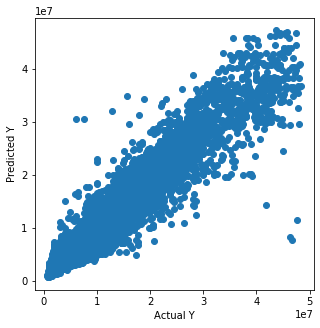

In [79]:
plt.figure(figsize=(5,5))
plt.scatter(y_test,xgb_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Random Forest**

In [53]:
model_rf = RandomForestRegressor(n_estimators = 100, max_depth=3, bootstrap=True, min_samples_leaf=25)
model_rf.fit(x_train, log_y_train)
rf_train_pred = np.expm1(model_rf.predict(x_train))
rf_test_pred = np.expm1(model_rf.predict(x_test))
print("RMSLE(train): ", rmsle(y_train, rf_train_pred))
print("RMSLE(test): ", rmsle(y_test, rf_test_pred))

RMSLE(train):  0.3077253146956986
RMSLE(test):  0.3071246074240017


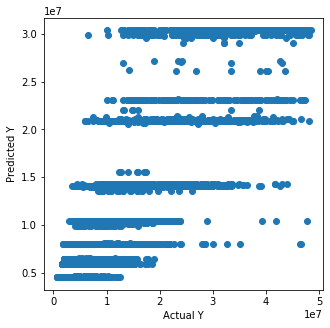

In [68]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, rf_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Linear Regression**

In [57]:
model_lr = LinearRegression()

model_lr.fit(x_train, log_y_train)
lr_train_pred = np.expm1(model_lr.predict(x_train))
lr_test_pred = np.expm1(model_lr.predict(x_test))
print("RMSLE(train): ", rmsle(y_train, lr_train_pred))
print("RMSLE(test): ", rmsle(y_test, lr_test_pred))

RMSLE(train):  0.26297928363678386
RMSLE(test):  0.2643469909179852


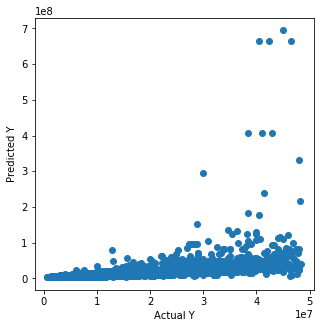

In [69]:
plt.figure(figsize=(5,5))
plt.scatter(y_test,lr_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**Lasso**

In [66]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train,log_y_train)
lasso_train_pred = np.expm1(model_lasso.predict(x_train))
lasso_test_pred = np.expm1(model_lasso.predict(x_test))

print("RMSLE(train): ", rmsle(y_train, lasso_train_pred))
print("RMSLE(test): ", rmsle(y_test, lasso_test_pred))

RMSLE(train):  0.2640358399292146
RMSLE(test):  0.265178470542687


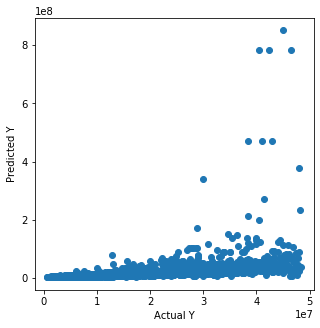

In [70]:
plt.figure(figsize=(5,5))
plt.scatter(y_test,lasso_test_pred)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

**ANN**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

model_ann = Sequential()

model_ann.add(Dense(x_train.shape[1],activation='relu'))
model_ann.add(Dense(32,activation='relu'))

model_ann.add(Dense(64,activation='relu'))

model_ann.add(Dense(128,activation='relu'))
model_ann.add(Dropout(0.2))
model_ann.add(Dense(1))

model_ann.compile(optimizer=Adam(0.001), loss='mse')

model_ann.fit(x_train, log_y_train, batch_size=128, epochs=500)

ann_train_pred = np.expm1(model_ann.predict(x_train))
ann_test_pred = np.expm1(model_ann.predict(x_test))
print("RMSLE(train): ", rmsle(y_train, ann_train_pred))
print("RMSLE(test): ", rmsle(y_test, ann_test_pred))

Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1031/1031 [==============================] - 2s 1ms/step - loss: 278763328.0000
Epoch 2/500
1031/1031 [==============================] - 2s 2ms/step - loss: 12630.4502
Epoch 3/500
1031/1031 [==============================] - 2s 2ms/step - loss: 114.0977A: 0
Epoch 4/500
1031/1031 [==============================] - 2s 2ms/step - loss: 141.7916
Epoch 5/500
1031/1031 [==============================] - 3s 2ms/step - loss: 168.8086
Epoch 6/500
1031/1031 [==============================] - 2s 2ms/st

1031/1031 [==============================] - 2s 2ms/step - loss: 0.2651
Epoch 88/500
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2651
Epoch 89/500
1031/1031 [==============================] - 2s 2ms/step - loss: 0.2651
Epoch 90/500
 341/1031 [========>.....................] - ETA: 1s - loss: 0.2685

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test,ann_test_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()